In [6]:
# @title install libraries
%%capture
!python -m pip install paddlepaddle PaddleOCR pyOpenSSL
!pip install datasets[audio]==3.6.0

In [7]:
# @title create ocr engine
%%capture
from paddleocr import PaddleOCR
from PIL import Image as PILImage
import gradio as gr

ocr = PaddleOCR(use_textline_orientation=False,
                use_doc_orientation_classify=False,
                use_doc_unwarping=False,
                lang='ch')

In [141]:
# @title step 1: ocr

import numpy as np
import cv2
from PIL import Image as PILImage
from PIL import ImageDraw
from PIL import ImageFont
from IPython.display import display
from IPython.display import Image as IPythonImage

def draw_ocr(image, boxes, polys, txts=None, scores=None, font_path='simfang.ttf'):
    """
    Draws OCR results (bounding boxes and recognized text) on an image.

    Args:
        image (PIL.Image or str): Input image (or path to image).
        boxes (list): List of bounding boxes, each with 4 points [[x1,y1],[x2,y2],[x3,y3],[x4,y4]].
        txts (list): List of recognized text strings for each box (optional).
        scores (list): Confidence scores for each recognized text (optional).
        font_path (str): Path to a TTF font that supports Chinese characters.

    Returns:
        PIL.Image: Annotated image with drawn boxes and text.
    """
    policy = lambda x,y,x1,y1, width,height : y > height * 2 / 3

    for box, poly, txt, score in zip(boxes, polys, txts, scores):
      print(box.shape, box[0],box[1],box[2],box[3], poly.shape, poly[0], poly[1], poly[2], poly[3], txt, score)

    # Load image if a file path is given
    if isinstance(image, str):
        image = PILImage.open(image).convert("RGB")

    draw = ImageDraw.Draw(image)
    width = image.width
    height = image.height
    print("width,height:",width, height)

    try:
        font = ImageFont.truetype(font_path, size=50)
    except IOError:
        # Use default font if specified font not found
        font = ImageFont.load_default()

    output_text = None
    output_rect = None
    # Iterate over each detected box
    for i, box in enumerate(boxes):
        # Draw polygon for bounding box
        x0,y0,x1,y1 =  box[0], box[1], box[2], box[3]
        if policy(x0,y0,x1,y1,width,height):
          draw.polygon([(x0,y0),(x0,y1),(x1,y1),(x1,y0)], outline="red", width=2)
          draw.polygon([(x0,y0),(x0,y0+2),(x0+2,y0+2)], outline="red", width=2)
          draw.polygon([(x1,y1),(x1,y1+2),(x1+2,y1+2)], outline="green", width=2)

        # Prepare label text
        label = ""
        if txts is not None and i < len(txts):
            label += txts[i]
        if scores is not None and i < len(scores):
            label += f" ({scores[i]:.2f})"

        # Draw text label above the box if available
        if label and policy(x0,y0,x1,y1,width,height):
          left, top, right, bottom = font.getbbox(label)
          x_mid = x0 + (x1 - x0) / 2
          y_mid = y0 + (y1 - y0) / 2
          x_min = x_mid - (right-left) / 2
          y_min = y0 - (bottom-top) - 20 # 20 is space
          draw.text((x_min, y_min), label, fill="blue", font=font)
          output_text = txts[i]
          output_score = scores[i]
          output_rect = np.array((x_min, y_min, x_min+right-left, y_min+bottom-top))

    return np.asarray(image), output_text, output_rect, output_score

def inference(img):
    img_path = img.name
    result = ocr.predict(img_path)
    '''
    for res in result:
      res.print()
      res.save_to_img("output")
      res.save_to_json("output")
    '''

    image = PILImage.open(img_path).convert('RGB')
    polys = result[0]['rec_polys']
    boxes = result[0]['rec_boxes']
    txts = result[0]['rec_texts']
    scores = result[0]['rec_scores']
    im_show, output_text, output_rect, output_score = draw_ocr(image, boxes, polys, txts, scores, font_path='simfang.ttf')
    im_show = PILImage.fromarray(im_show)
    im_show.save('result.jpg')
    return output_text, output_rect, output_score

from dataclasses import dataclass

@dataclass
class InputImage:
  name: str
output_text, output_rect, output_score = inference(InputImage(name = 'ss.png'))

#display(IPythonImage('result.jpg'))
#display(IPythonImage('output/ss_ocr_res_img.png'))

(4,) 1366 27 1497 88 (4, 2) [1366   27] [1497   27] [1497   88] [1366   88] bilibili 0.9057722091674805
(4,) 1244 41 1371 81 (4, 2) [1244   41] [1371   41] [1371   81] [1244   81] 小狮日记 0.9987596869468689
(4,) 1072 134 1255 168 (4, 2) [1072  137] [1254  134] [1255  165] [1072  168] Esa 0.12536169588565826
(4,) 296 203 564 471 (4, 2) [429 203] [564 325] [432 471] [296 349] 小 0.06775876134634018
(4,) 1452 259 1499 420 (4, 2) [1452  259] [1499  259] [1499  420] [1452  420] 专业改造 0.998469889163971
(4,) 1453 453 1497 611 (4, 2) [1453  453] [1497  453] [1497  611] [1453  611] 请勿模仿 0.9940035343170166
(4,) 582 786 918 844 (4, 2) [583 786] [918 789] [917 844] [582 842] 螺旋桨就会启动 0.9976547360420227
width,height: 1518 870


In [9]:
# @title step 2: translate

from transformers import AutoTokenizer, AutoModelForSeq2SeqLM

print("text:", output_text, " rect:", output_rect, " score:", output_score)
from transformers import MarianMTModel, MarianTokenizer

# Load the model and tokenizer
model_name = "Helsinki-NLP/opus-mt-zh-en"
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForSeq2SeqLM.from_pretrained(model_name)

# Input text (Chinese)
input_text = output_text #"你好世界"

# Tokenize the input
inputs = tokenizer(input_text, return_tensors="pt")

# Generate the translation
translated_tokens = model.generate(**inputs)

# Decode the translation
translated_text = tokenizer.decode(translated_tokens[0], skip_special_tokens=True)

print(translated_text)
# Expected output (approximately): Hello world

text: 螺旋桨就会启动  rect: [487.5 ... 766. ]  score: 0.9976547360420227


/usr/local/lib/python3.11/dist-packages/transformers/models/marian/tokenization_marian.py:175: UserWarning: Recommended: pip install sacremoses.
  warnings.warn("Recommended: pip install sacremoses.")


The propeller will be activated.


In [142]:
# @title step 3: tts

from transformers import SpeechT5Processor, SpeechT5ForTextToSpeech, SpeechT5HifiGan
import torch
from IPython.display import Audio
from datasets import load_dataset

device = "cuda:0" if torch.cuda.is_available() else "cpu"

processor = SpeechT5Processor.from_pretrained("microsoft/speecht5_tts")

model = SpeechT5ForTextToSpeech.from_pretrained("microsoft/speecht5_tts")
vocoder = SpeechT5HifiGan.from_pretrained("microsoft/speecht5_hifigan")

model.to(device)
vocoder.to(device)

embeddings_dataset = load_dataset("Matthijs/cmu-arctic-xvectors", split="validation")
speaker_embeddings = torch.tensor(embeddings_dataset[1234]["xvector"]).unsqueeze(0) #7306: yound woman

def synthesise(text):
    inputs = processor(text=text, return_tensors="pt")
    speech = model.generate_speech(
        inputs["input_ids"].to(device), speaker_embeddings.to(device), vocoder=vocoder
    )
    return speech.cpu()

#speech = synthesise("Hey there! This is a test!")
#Audio(speech, rate=16000)

In [130]:
# @title test
import soundfile as sf

speech = synthesise(translated_text)
display(Audio(speech, rate=16000))

audio_out_file = 'audio.mp3'
samplerate = 16_000
#sf.write(audio_out_file, speech, samplerate)
sf.write(audio_out_file, speech, samplerate, format='MP3', bitrate_mode='VARIABLE', compression_level=0.8)
display(Audio(audio_out_file))
print("audio saved as 'audio.mp3'")

audio saved as 'audio.mp3'


In [138]:
# @title step 4: create video

print("translated_text:",translated_text,
      "output_rect:", output_rect[0],output_rect[1],output_rect[2],output_rect[3],
      "output_score:", output_score,
      "output_text:",output_text)

def render_text(image, text, output_rect, font_path='simfang.ttf'):
    # Load image if a file path is given
    if isinstance(image, str):
        image = PILImage.open(image).convert("RGB")

    draw = ImageDraw.Draw(image)
    width = image.width
    height = image.height
    print("width,height:",width, height)

    try:
        font = ImageFont.truetype(font_path, size=50)
    except IOError:
        # Use default font if specified font not found
        font = ImageFont.load_default()

    # Draw text label above the box if available
    x0, y0, x1, y1 = output_rect
    left, top, right, bottom = font.getbbox(text)
    x_mid = x0 + (x1 - x0) / 2
    y_mid = y0 + (y1 - y0) / 2
    x_min = x_mid - (right-left) / 2
    y_min = y0# - (bottom-top)
    draw.text((x_min, y_min), text, fill="white", font=font)

    return np.asarray(image)

renderred_image = render_text("ss.png", translated_text, output_rect, font_path='simfang.ttf')
im_show = PILImage.fromarray(renderred_image)
im_show.save('rendered_image.jpg')
#display(IPythonImage('rendered_image.jpg'))

# save into video file
import cv2

height, width, channels = renderred_image.shape

fourcc = cv2.VideoWriter_fourcc(*'mp4v') # Codec for MP4

fps = 1 # Frames per second
frame_size = (width, height) # Width and height of frames

out = cv2.VideoWriter('video.mp4', fourcc, fps, frame_size)

if out.isOpened():
  for i in range(1):
    frame_bgr = cv2.cvtColor(renderred_image, cv2.COLOR_RGB2BGR)
    out.write(frame_bgr.astype('uint8'))
    print("frame", i, "saved")
else:
  print("Error opening video writer")

# Release the VideoWriter object
out.release()
cv2.destroyAllWindows()
print("Video saved as 'video.mp4'")

translated_text: The propeller will be activated. output_rect: 487.5 718.0 1012.5 766.0 output_score: 0.9976547360420227 output_text: 螺旋桨就会启动
width,height: 1518 870
frame 0 saved
Video saved as 'video.mp4'


In [139]:
# @title compile video
from IPython.display import Video, display

video_out_file = 'output.mp4'
!ffmpeg -i video.mp4 -c:v libx264 -crf 0 output_video.mp4 -y # mp4v to avc1
!ffmpeg -i output_video.mp4 -i audio.wav -map 0:v:0 -map 1:a:0 -c:a aac -b:a 128k output.mp4 -y

ffmpeg version 4.4.2-0ubuntu0.22.04.1 Copyright (c) 2000-2021 the FFmpeg developers
  built with gcc 11 (Ubuntu 11.2.0-19ubuntu1)
  configuration: --prefix=/usr --extra-version=0ubuntu0.22.04.1 --toolchain=hardened --libdir=/usr/lib/x86_64-linux-gnu --incdir=/usr/include/x86_64-linux-gnu --arch=amd64 --enable-gpl --disable-stripping --enable-gnutls --enable-ladspa --enable-libaom --enable-libass --enable-libbluray --enable-libbs2b --enable-libcaca --enable-libcdio --enable-libcodec2 --enable-libdav1d --enable-libflite --enable-libfontconfig --enable-libfreetype --enable-libfribidi --enable-libgme --enable-libgsm --enable-libjack --enable-libmp3lame --enable-libmysofa --enable-libopenjpeg --enable-libopenmpt --enable-libopus --enable-libpulse --enable-librabbitmq --enable-librubberband --enable-libshine --enable-libsnappy --enable-libsoxr --enable-libspeex --enable-libsrt --enable-libssh --enable-libtheora --enable-libtwolame --enable-libvidstab --enable-libvorbis --enable-libvpx --enab

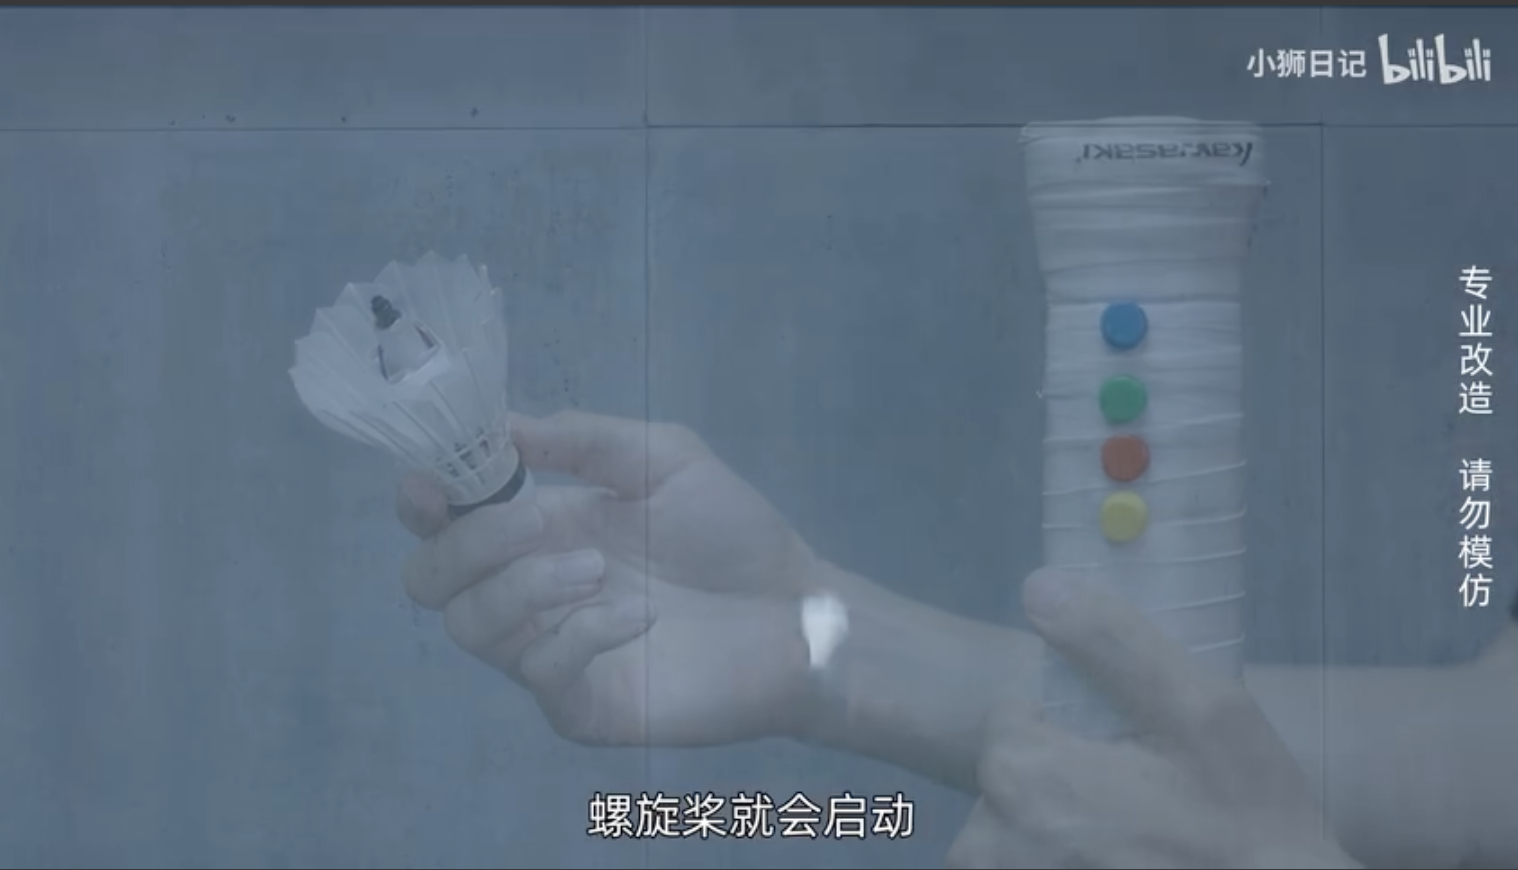

In [150]:
# @title result

from IPython.display import HTML
from base64 import b64encode

mp4 = open('output.mp4','rb').read()
data_url = "data:video/mp4;base64," + b64encode(mp4).decode()
display(HTML("""
<video width=800 controls>
      <source src="%s" type="video/mp4">
</video>
""" % data_url))


display(IPythonImage('ss.png', width=800))

In [ ]:
# @title gradio
'''
title = 'PaddleOCR'
description = 'Gradio demo for PaddleOCR. To use it, simply upload your image, or click one of the examples to load them. Read more at the links below.'
article = "<p style='text-align: center'><a href='https://arxiv.org/abs/2104.05703'>Adversarial Open Domain Adaption for Sketch-to-Photo Synthesis</a> | <a href='https://github.com/Mukosame/Anime2Sketch'>Github Repo</a></p>"

demo = gr.Interface(
    inference,
    gr.Image(type='filepath', label='Input'),
    gr.Image(type='filepath', label='Output'),
    title=title,
    description=description,
    article=article,
    )

if __name__ == "__main__":
    demo.launch(debug=True)
'''